# Point cloud SubSampling with PythonLidar

## Imports

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [3]:
from python_lidar import PythonLidar
pl = PythonLidar(epsg=4326)

2021-08-22 12:42:26,501 — FileHandler — INFO — usgs_3dep_metadata read successfully


## Fetch USGS 3DEP Lidar data

In [4]:
gpd = pickle.load(open("../data/pickle/filename.pickle", "rb"))
df = gpd[0]['geo_data'].copy()
df

,elevation,geometry
0,317.59,POINT (-93.74864 41.92142)
1,317.42,POINT (-93.74863 41.92142)
2,317.27,POINT (-93.74862 41.92142)
3,317.28,POINT (-93.74865 41.92142)
4,317.25,POINT (-93.74867 41.92142)
...,...,...
403326,317.77,POINT (-93.75259 41.91930)
403327,313.97,POINT (-93.74782 41.91812)
403328,315.01,POINT (-93.74940 41.91812)
403329,315.62,POINT (-93.75100 41.91812)


In [6]:
sub_sampler = pl.get_sub_sampler(32643, df)
sub_sampler.df

,elevation,geometry
0,317.59,POINT (-433579.780 15293214.755)
1,317.42,POINT (-433580.829 15293214.873)
2,317.27,POINT (-433581.528 15293215.506)
3,317.28,POINT (-433578.449 15293215.197)
4,317.25,POINT (-433577.418 15293215.099)
...,...,...
403326,317.77,POINT (-433282.564 15293495.282)
403327,313.97,POINT (-433696.256 15293572.872)
403328,315.01,POINT (-433565.195 15293590.919)
403329,315.62,POINT (-433432.124 15293608.869)


In [7]:
sample_df = sub_sampler.decimation(50)
sample_df

,elevation,geometry
0,317.59,POINT (-433579.780 15293214.755)
1,317.08,POINT (-433563.374 15293218.063)
2,316.97,POINT (-433548.459 15293218.532)
3,316.99,POINT (-433548.354 15293220.597)
4,317.38,POINT (-433565.897 15293224.470)
...,...,...
8062,315.05,POINT (-433663.595 15293539.437)
8063,315.27,POINT (-433665.250 15293532.801)
8064,315.45,POINT (-433663.993 15293526.891)
8065,315.78,POINT (-433707.952 15293508.411)


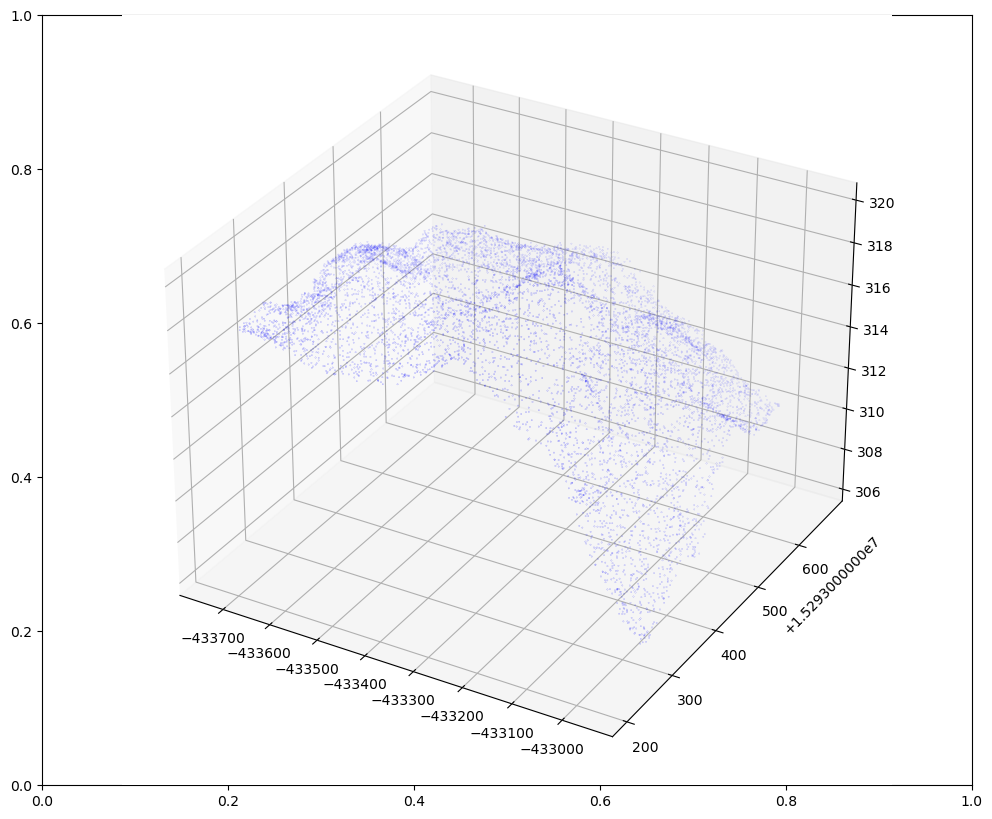

In [8]:
vis = pl.get_renderer(sample_df)
vis.render_3d()

In [44]:
import os
import elevation
import matplotlib
import numpy as np
import richdem as rd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import point
from gpd_helper import GPDHelper


class SubSampler:
  """ Point Clouds Sampler Class that can implement Factor, BaryCenter or Relative Distance Samplings .
  """

  def __init__(self, input_epsg: int, output_epsg: int, df: gpd.GeoDataFrame):
    self._gpd_helper = GPDHelper(input_epsg, output_epsg)
    self.df = self._gpd_helper.covert_crs(df)

  def get_points(self):
    """ Generate numpy array of points from point clouds data.
    """
    x = self.df.geometry.x
    y = self.df.geometry.y
    z = self.df.elevation
    return np.array([x, y, z]).transpose()

  def decimation(self, factor: int = 20):
    points = self.get_points()
    decimated_points = points[::factor]
    return self._gpd_helper.get_dep_points(decimated_points)

  def get_voxel_grid(self, points, voxel_size: float):
    nb_vox = np.ceil((np.max(points, axis=0)
                     - np.min(points, axis=0)) / voxel_size)
    non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(
        ((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
    idx_pts_vox_sorted = np.argsort(inverse)
    return nb_vox, non_empty_voxel_keys, nb_pts_per_voxel, idx_pts_vox_sorted

  def grid_barycenter(self, voxel_size: int):
    last_seen = 0
    voxel_grid = {}
    grid_barycenter = []
    points = self.get_points()
    nb_vox, non_empty_voxel_keys, nb_pts_per_voxel, idx_pts_vox_sorted = self.get_voxel_grid(
        points, voxel_size)

    for idx, vox in enumerate(non_empty_voxel_keys):
      voxel_grid[tuple(vox)] = points[idx_pts_vox_sorted[last_seen:last_seen + nb_pts_per_voxel[idx]]]
      grid_barycenter.append(np.mean(voxel_grid[tuple(vox)], axis=0))
      last_seen += nb_pts_per_voxel[idx]
    sample_points = np.array(list(map(list, grid_barycenter)))
    return self._gpd_helper.get_dep_points(sample_points)


  def grid_candidate_center(self, voxel_size: int):
      last_seen = 0
      voxel_grid = {}
      grid_candidate_center = []
      points = self.get_points()
      nb_vox, non_empty_voxel_keys, nb_pts_per_voxel, idx_pts_vox_sorted = self.get_voxel_grid(
          points, voxel_size)

      for idx, vox in enumerate(non_empty_voxel_keys):
        voxel_grid[tuple(vox)] = points[idx_pts_vox_sorted[last_seen:last_seen + nb_pts_per_voxel[idx]]]
        grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(
            voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)], axis=0), axis=1).argmin()])
        last_seen += nb_pts_per_voxel[idx]
      
      sample_points = np.array(list(map(list, grid_candidate_center)))
      return self._gpd_helper.get_dep_points(sample_points)


In [45]:
sub_sampler = SubSampler(26915, 32643, df)

In [46]:
sample_df = sub_sampler.decimation(50)
sample_df

,elevation,geometry
0,317.59,POINT (-433579.780 15293214.755)
1,317.08,POINT (-433563.374 15293218.063)
2,316.97,POINT (-433548.459 15293218.532)
3,316.99,POINT (-433548.354 15293220.597)
4,317.38,POINT (-433565.897 15293224.470)
...,...,...
8062,315.05,POINT (-433663.595 15293539.437)
8063,315.27,POINT (-433665.250 15293532.801)
8064,315.45,POINT (-433663.993 15293526.891)
8065,315.78,POINT (-433707.952 15293508.411)


In [50]:
sample_df = sub_sampler.grid_barycenter(5)
sample_df

,elevation,geometry
0,314.900000,POINT (-433733.289 15293540.223)
1,314.792857,POINT (-433733.463 15293543.326)
2,314.716364,POINT (-433733.705 15293548.043)
3,314.541875,POINT (-433733.848 15293552.952)
4,314.491600,POINT (-433734.350 15293557.822)
...,...,...
12212,306.417059,POINT (-432956.587 15293298.652)
12213,306.487619,POINT (-432956.975 15293302.656)
12214,306.487500,POINT (-432957.209 15293307.642)
12215,306.530000,POINT (-432957.595 15293312.504)


In [51]:
sample_df = sub_sampler.grid_candidate_center(5)
sample_df

,elevation,geometry
0,314.90,POINT (-433733.289 15293540.223)
1,314.71,POINT (-433733.570 15293543.371)
2,314.76,POINT (-433733.916 15293548.312)
3,314.56,POINT (-433733.587 15293552.412)
4,314.36,POINT (-433734.273 15293558.314)
...,...,...
12212,306.32,POINT (-432956.927 15293298.275)
12213,306.54,POINT (-432957.352 15293302.327)
12214,306.44,POINT (-432957.101 15293307.702)
12215,306.49,POINT (-432957.266 15293312.712)
